## Autoencoder and Variational Autoencoder

本單元，我們將介紹並帶各位同學實作非監督式學習中的自編碼器及其變形。

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1tdNpYWaO0lNom51QwY5zcoefjpOhIHu0", width="70%"
   />
</p>

## 1: 切換 TensorFlow 版本及匯入所需套件

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 2: 下載並整理資料集
老規矩，開場先發動覆蓋的魔法卡，召喚 MNIST 資料集

In [0]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

## 3 Autoencoder

Autoencoder，又稱為自編碼器，是一個將資料壓縮再還原的模型，通常由一編碼器及一解碼器所組成。

給定一組數據集 $\mathcal{D}\subseteq\mathbb{R}^n$ 以及一個壓縮維度 $m$，其中 $m < n$。

數學上來說表示，Autoencoder 由 $\mbox{Enc}:\mathbb{R}^n\to\mathbb{R}^m$ 和 $\mbox{Dec}:\mathbb{R}^m\to\mathbb{R}^n$ 所構成：

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\mbox{Enc}}{\mapsto} z \overset{\mbox{Dec}}{\mapsto} \hat{x} $$

其中，$z = \mbox{Enc}(x)$ 稱之 $x$ 透過 Encdoer 得到的潛在表示法 (latent representation)。

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1lkH51DUsq-DKKYq2r5r-Pw3JssIdtIj6", width="40%"
   />
</p>

Decoder 的目的則是將潛在空間 (Latent Sapce) 裡的元素轉換為特徵空間 (Feature Space) 中的元素，因此，我們希望 Decoder 能將 $x$ 的潛在表示 $z$，還原成 $\hat{x}$。


<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1alk_L7D5TtF85kaMRQ-s_HUcHE0Bh0Qj", width="40%"
   />
</p>


Autoencodr 就是一組函數 ($Enc$, $Dec$) 使得，對於任意的 $x\in\mathcal{D}$，$x\approx\hat{x} = Dec(z) = Dec\big(Enc(x)\big)$


**為了視覺化的目的，經常會考慮 $m=2$ 的狀況。**

### 3.1 Autoencoder

我們考慮具有下列結構的 Autoencoder:

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=15YLGgg9DbiJjArWi6-IBssMSM5cxQmhg", width="80%"
   />
</p>


為了方便，我們將三個變數的符號表示出來：

$$ x \overset{\mbox{Enc}}{\mapsto} z \overset{\mbox{Dec}}{\mapsto} \hat{x} $$

In [0]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

z = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(z))

In [0]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_31 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_32 (Dense)             (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


一樣的，當模型 compile 之後，便可以進行資料的訓練、預測等等，請有興趣的同學讀入 MNIST 手寫辨識之料後，自行完成這個模型的訓練。

In [0]:
autoencoder.compile(loss='mse',
                    optimizer=Adam(5e-3),
                    metrics='mae'
                    )

autoencoder.load_weights('autoencoder_mse_mae_weights.h5')

In [0]:
autoencoder.fit(X_train, X_train, 
                batch_size=512, 
                epochs=5,  
                validation_data=(X_test, X_test)
                )

autoencoder.save_weights('autoencoder_mse_mae_weights.h5')

Epoch 1/5
118/118 [==============================] - 2s 19ms/step - loss: 0.0721 - mae: 0.1661 - val_loss: 0.0649 - val_mae: 0.1493
Epoch 2/5
118/118 [==============================] - 2s 18ms/step - loss: 0.0623 - mae: 0.1449 - val_loss: 0.0608 - val_mae: 0.1421
Epoch 3/5
118/118 [==============================] - 2s 18ms/step - loss: 0.0588 - mae: 0.1390 - val_loss: 0.0574 - val_mae: 0.1367
Epoch 4/5
118/118 [==============================] - 2s 18ms/step - loss: 0.0567 - mae: 0.1339 - val_loss: 0.0561 - val_mae: 0.1321
Epoch 5/5
118/118 [==============================] - 2s 18ms/step - loss: 0.0559 - mae: 0.1313 - val_loss: 0.0555 - val_mae: 0.1308


### 3.2 視覺化 - 資料還原與還原誤差

In [0]:
def reconstructed_img(idx):
    # Prepare image to be reconstructed
    X = X_train[idx:idx+1]
    y = y_train0[idx]
    X_hat = autoencoder.predict(X)

    # Reshape for plotting  
    X = X.reshape(28, 28)
    X_hat = X_hat.reshape(28, 28)
    rec_error = np.abs(X-X_hat)

    # Prepare a canvas for plotting
    plt.figure(figsize=(12, 9))
    ax1 = plt.subplot2grid((2,3),(0,0))
    ax2 = plt.subplot2grid((2,3),(0,1))
    ax3 = plt.subplot2grid((2,3),(0,2))
    ax4 = plt.subplot2grid((2,3),(1,0), colspan=3)

    # Plot raw image
    ax1.imshow(X, 'Greys')
    ax1.set_title(f'Number: {y}')

    # Plot reconstructed image
    ax2.imshow(X_hat, 'Greys')
    ax2.set_title('Reconstructed Image')

    # Plot reconstruction error
    ax3.imshow(rec_error, 'Greys')
    ax3.set_title('Reconstructed Error')
    ax4.hist(rec_error.flatten(), bins=20, rwidth=0.5)
    ax4.set_title('Histogram of Reconstructed Error')

In [0]:
# Plot
interact(reconstructed_img, idx=IntSlider(min=0, max=X_train.shape[0], step=1, value=3));

interactive(children=(IntSlider(value=5566, description='idx', max=60000), Output()), _dom_classes=('widget-in…

### 3.3 Encoder 與 Decoder
為了視覺化(及其他潛在應用)，我們也會從 Autoencoder 將 Encoder 和 Decoder 分別定義出來。

In [0]:
Encoder = Model(x, z)
Encoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [0]:
# 此為錯誤範例
Decoder = Model(z, x_hat)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: dense_30/Identity:0


ValueError: ignored

Decoder 是由 $h$ 開始，因此，我們先準備一個與 $h$ 相同大小的 `Input`，並餵進 `dec_2` 及 `dec_1` 中即可。

In [0]:
z_input = Input(shape=(2,))
Decoder = Model(z_input, dec_1(dec_2(z_input)))

Decoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_31 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_32 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


### 3.4 視覺化 - Encoder

首先，我們隨便抽取一張圖，並透過 Encoder 來算出它的 latent 表示。

In [0]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 50566 圖的 latent 表示為 [0.26634747 0.09455414]


接者，我們從 $10000$ 筆測試資料隨機挑選 $3000$ 手寫辨識資料，將其轉換成 latent 表示法，並畫在同一平面上。

In [0]:
indices = np.random.randint(X_train.shape[0], size=3000)

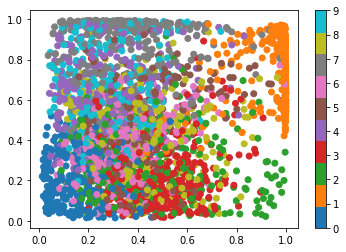

In [0]:
latents = Encoder.predict(X_train[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_train0[indices], cmap="tab10")
plt.colorbar()
plt.show()

### 2.4 視覺化 - Decoder

首先，我們在 $[0, 1]\times[0, 1]$ 這個單位正方形內均勻取樣 $15*15$ 個點，並將這 $225$ 個平面上的點，透過 Decoder 進行圖片的還原。

In [0]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [0]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

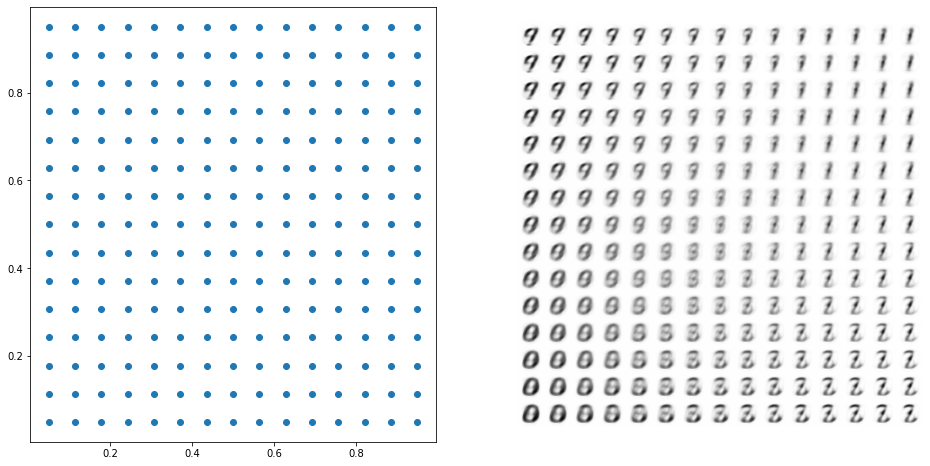

In [0]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XX, YY = np.meshgrid(grid_x, grid_y)
plt.scatter(XX, YY)

plt.subplot(1, 2, 2)
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()

# 4.Variational Autoencoder
若每筆資料的 Latent 不僅僅是一個**位置**，而是一個分佈 (distribution) 的參數 (parameter)

如果我們希望透過抽樣 (sampling) 的方式還原圖片

在此，我們將介紹 Variational Autoencder，一種當代知名的自編碼器，就具有上述的效果。

此時 $\mbox{Enc}$ 和 $\mbox{Dec}$ 並不直接串接，而是會透過一常態抽樣的函數以下面的形式串接。

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m\times\mathbb{R}^m \overset{\mbox{Sampling}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1HTd5YK74Oset4s1lhpRofJikLBE1oRRl", width="70%"
   />
</p>

我們準備建構的 Variational Autoencoder 的結構如下：

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1eqRXtERBAF2jI6sgkUltucQ-JYPt0bCq", width="70%"
   />
</p>

在此， Encoder 的作用不是將資料表示成 latent，而是將資料表示成常態分配的兩個參數，平均數與變異數。

而 Decoder 也不再直接使用 Encoder 的結果，而是將 Encoder 的結果作為常態抽樣的兩個參數來進行。

因此，資料經過 Encoder，會得到一適當大小的常態分配之參數，而 Decoder 則使用這組參數進行抽樣。

即使是同一筆資料，Decoder 每次接受到的 latent 表示法可能都不一樣 (但會在某個平均數附近)。

要注意到的是，由於變異數恆正的特性，我們可以下面是以學習取對數後的變異數 (log-variance)。

## 4.1 VAE 的建立
為了避免混淆，我們重新定義所有變數，首先，我們定義 Encoder 上的三個神經網路層

In [0]:
enc_1 = Dense(100, activation='sigmoid')
# enc_2 = Dense(2, activation='relu')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [0]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

定義抽樣函數並透過 ``Lambda`` 將其轉換成 Keras layer。

透過 $X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$，我們透過以下方式定義抽樣函數。

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon    

In [0]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [0]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))

In [0]:
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 100)          78500       input_18[0][0]                   
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 2)            202         dense_48[0][0]                   
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 2)            202         dense_48[0][0]                   
___________________________________________________________________________________________

## 4.2 Loss 函數的建立
VAE 的 loss 函數，其由來牽扯一些訊息理論 (information theory) 的知識，因此，我們在此直接建立訓練 VAE 時的 loss 函數。

首先，我們要知道的是 KL-散度 (Kullback-Leibler divergence)

對於兩個機率分佈 $P$ 跟 $Q$，$P$ 相對於 $Q$ 的 KL 定義為:
$$
DL(P||Q) = E_{P}\bigg[\frac{dP}{dQ}\bigg]
$$

若 $p$ 與 $q$ 分別為 $P$ 與 $Q$ 的機率密度函數 (pdf)，則
$$
DL(P||Q) = \int_{-\infty}^\infty p(x)\frac{p(x)}{q(x)} dx.
$$

若對 VAE 的理論及模型基本設定有興趣的同學，可以參考下列兩篇論文：
* Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
* Tutorial on Variational Autoencoders: https://arxiv.org/pdf/1606.05908.pdf

同學有興趣可以證明下面關於 KL 散度在兩個常態分配上的性質：

若 $p\sim N(\mu_1,\sigma_1^2)$, $q\sim N(\mu_2,\sigma_2^2)$，則 
$$
KL(p, q) = \log\dfrac{\sigma_2}{\sigma_1} + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\dfrac{1}{2}.
$$

如果 $q\sim N(0, 1)$，則
$$
KL(p, q) = -\frac{1}{2}\bigg[1+\log\sigma_1^2-\mu_1^2-\sigma_1^2\bigg].
$$

In [0]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.binary_crossentropy(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

## 4.3 訓練 VAE

In [0]:
VAE.compile(optimizer=Adam())

VAE.load_weights('VAE_handwriting_model_weights.h5')

In [0]:
VAE.fit(X_train, X_train, 
        batch_size=512, 
        epochs=20)

VAE.save_weights('VAE_handwriting_model_weights.h5')

## 4.4 VAE 的視覺化呈現
與 Autoencoder 一樣，我們來視覺化 VAE 上的 Encoder 跟 Decoder

$$\mbox{VAE:}~x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$
$$\mbox{Encoder:}~x \overset{\mbox{Enc}}{\mapsto} \mu$$
$$\mbox{Decoder:}~h \overset{\mbox{Dec}}{\mapsto} \hat{x}$$

In [0]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [0]:
VAE_Decoder = Model(z_input, dec_1(dec_2(z_input)))

VAE_Decoder.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_51 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_52 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


首先，我們進行 Encoder 的視覺化呈現。

In [0]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 6844 圖的 latent 表示為 [-0.5986847 -0.8256524]


In [0]:
VAE_latents = VAE_Encoder.predict(X_train[indices])

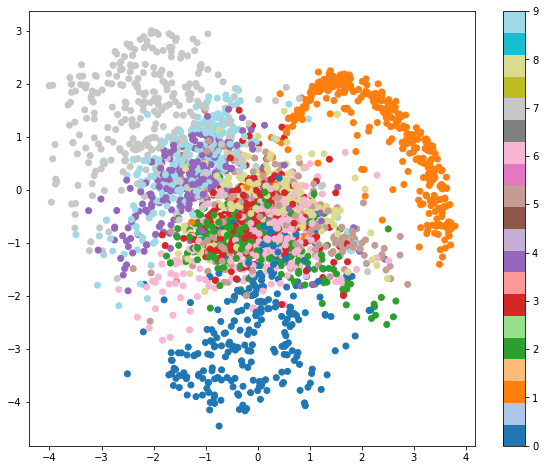

In [0]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

接著，我們進行 Decoder 的視覺化呈現。

In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

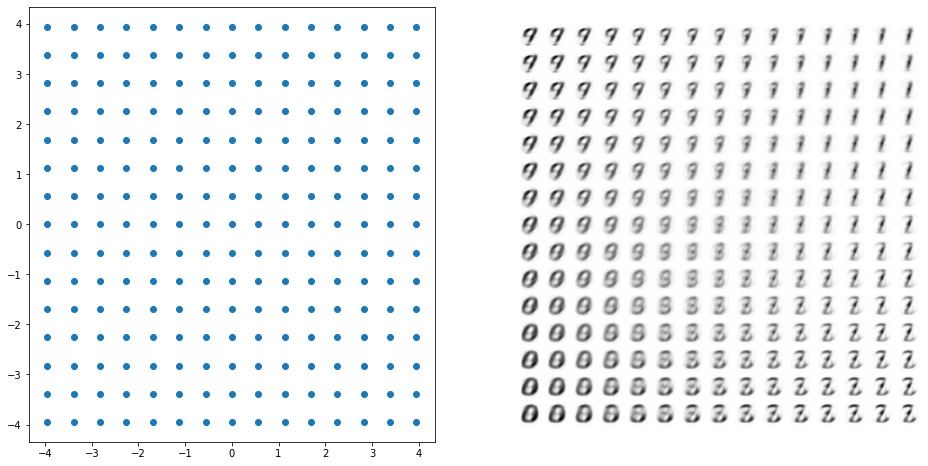

In [0]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()

## 4.5 與 Autoencoder 的 Encoder 進行視覺化比較

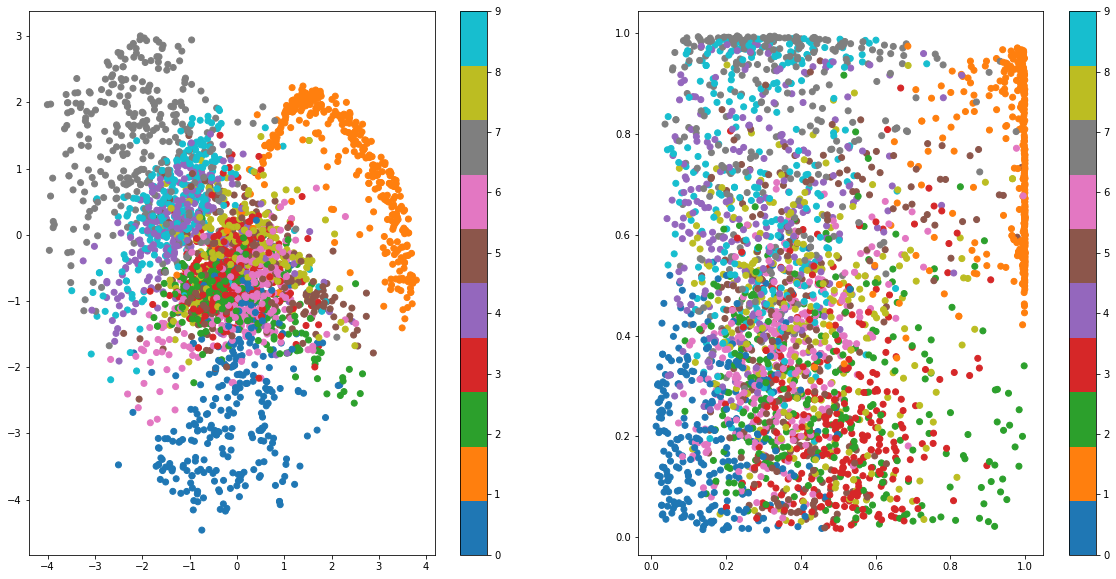

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab10')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_train0[indices], cmap="tab10")
plt.colorbar()
plt.show()

## 4.6 動態比較

In [0]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [0]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [0]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween>